In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging.
But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1.Use DuckDuckGo to search for images of "bird photos"
2.Use DuckDuckGo to search for images of "forest photos"
3.Fine-tune a pretrained neural network to recognise these two groups
4.Try running this model on a picture of a bird and see if it works.

In [16]:
#pip install fastbook

In [3]:
from fastbook import *

In [4]:
urls = search_images_ddg('bird photos', max_images= 1)
len(urls),urls[0]

(1,
 'http://1.bp.blogspot.com/-dz25YZGJcBI/T3APgAupHrI/AAAAAAAACrc/sGGgSOisr68/s1600/beautiful-birds-3.Jpg')

In [5]:
dest = Path('bird.jpg')
if not dest.exists(): download_url(urls[0], dest, show_progress=False)

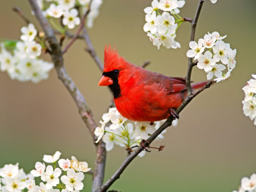

In [6]:
im = Image.open(dest)
im.to_thumb(256,256)

In [10]:
from pathlib import Path

searches = ['forest', 'bird']
path = Path('bird_or_not')

if not path.exists():
    path.mkdir(parents=True, exist_ok=True)

for o in searches:
  dest = (path/o)
  dest.mkdir(parents=True,exist_ok=True)
  results = search_images_ddg(f'{o} photo')
  download_images(dest, urls= results[:200])
  resize_images(dest, max_size= 400, dest= dest)

In [11]:
path

Path('bird_or_not')

In [12]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink);

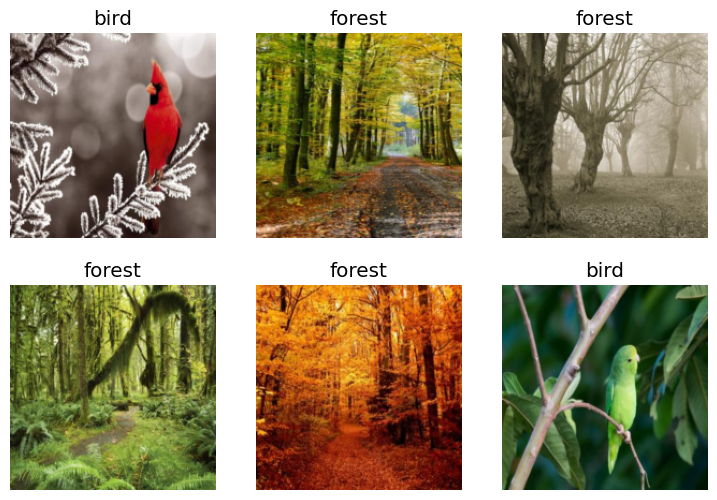

In [13]:
# DataBlocks gives all the information that fast.ai needs to create a deep learning model
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # fast.ai can define the best model for this information
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')] # resize to be 192 to 192 pixles
).dataloaders(path, bs=32)

dls.show_batch(max_n=6) # an example of a batch that the model will use

Here what each of the DataBlock parameters means:

**blocks=(ImageBlock, CategoryBlock):** The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

**get_items=get_image_files:** To find all the inputs to our model, run the get_image_files function (which returns a list of all image files in a path).

**splitter=RandomSplitter(valid_pct=0.2, seed=42):** Split the data into training and validation sets randomly, using 20% of the data for the validation set.

**get_y=parent_label:** The labels (y values) is the name of the parent of each file (i.e. the name of the folder they're in, which will be bird or forest).

**item_tfms=[Resize(192, method='squish')]:** Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is resnet18. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

fastai comes with a helpful fine_tune() method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [14]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 67.4MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.766612,0.212555,0.053333,00:47


epoch,train_loss,valid_loss,error_rate,time
0,0.036481,0.001254,0.000000,01:13
1,0.019239,0.000570,0.000000,01:17
2,0.021519,0.000195,0.000000,01:12


In [15]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000
